In [1]:
import catboost as cb
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
df = pd.read_csv('earthquakes.csv')

df.time = pd.to_datetime(df.time)
df = df.loc[df.time >= "1994-01-01"]
df = df.sort_values("time")
df = df.set_index("time")

df["region"] = df.place.str.split(", ", expand=True)[1]
df.region = df.region.fillna(df.place)
df.region = df.region.replace({"CA": "California", "B.C.": "Baja California"})

regions = df.region.value_counts()
top_k = 25
top_k_regions = regions.head(top_k).index
print(top_k_regions)

Index(['California', 'Alaska', 'Nevada', 'Hawaii', 'Washington', 'Utah',
       'Montana', 'Puerto Rico', 'Indonesia', 'Chile', 'Baja California',
       'Oklahoma', 'Japan', 'Greece', 'Papua New Guinea', 'Philippines',
       'Mexico', 'Italy', 'Russia', 'Idaho', 'Aleutian Islands', 'Tonga',
       'Oregon', 'Wyoming', 'Turkey'],
      dtype='object', name='region')


In [3]:
model = cb.CatBoostRegressor(cat_features=['region'])
model = model.load_model('multi_output_4_model')

In [4]:
start_lag = 3
end_lag = 3
features = (
    [
        "day",
        "dayofweek",
        "dayofyear",
        f"mag_rolling_mean_{start_lag}",
        f"mag_rolling_std_{start_lag}",
        f"depth_rolling_mean_{start_lag}",
        f"depth_rolling_std_{start_lag}",
        f"latitude_rolling_mean_{start_lag}",
        f"latitude_rolling_std_{start_lag}",
        f"longitude_rolling_mean_{start_lag}",
        f"longitude_rolling_std_{start_lag}",
        # f"mag_rolling_mean_{end_lag}",
        # f"mag_rolling_std_{end_lag}",
        # f"depth_rolling_mean_{end_lag}",
        # f"depth_rolling_std_{end_lag}",
    ]
    + [f"mag_lag_{i}" for i in range(start_lag, end_lag + 1)]
    + [f"depth_lag_{i}" for i in range(start_lag, end_lag + 1)]
    + [f"latitude_lag_{i}" for i in range(start_lag, end_lag + 1)]
    + [f"longitude_lag_{i}" for i in range(start_lag, end_lag + 1)]
)
cat_features = ["region"]
target = ["mag", "depth", "latitude", "longitude"]

In [5]:
live_data = pd.read_csv(
    "https://earthquake.usgs.gov/fdsnws/event/1/query?format=csv&eventtype=earthquake&limit=20000"
)
live_data.time = pd.to_datetime(live_data.time)
live_data = live_data.sort_values("time")
live_data = live_data.set_index("time")

live_data["region"] = live_data.place.str.split(", ", expand=True)[1]
live_data.region = live_data.region.fillna(live_data.place)
live_data.region = live_data.region.replace({"CA": "California", "B.C.": "Baja California"})

live_data = live_data.loc[live_data.region.isin(top_k_regions)]

live_data = live_data[["depth", "mag", "region", 'latitude', 'longitude']]

live_data = live_data.groupby("region").resample("d").mean().reset_index()
live_data.mag = live_data.groupby("region").mag.ffill()
live_data.depth = live_data.groupby("region").depth.ffill()
live_data.latitude = live_data.groupby("region").latitude.ffill()
live_data.longitude = live_data.groupby("region").longitude.ffill()

live_data["day"] = live_data.time.dt.day
live_data["dayofweek"] = live_data.time.dt.dayofweek
live_data["dayofyear"] = live_data.time.dt.dayofyear

for i in range(start_lag, end_lag + 1):
    live_data[f"mag_lag_{i}"] = live_data.groupby("region").mag.shift(i)

for i in range(start_lag, end_lag + 1):
    live_data[f"depth_lag_{i}"] = live_data.groupby("region").depth.shift(i)

for i in range(start_lag, end_lag + 1):
    live_data[f"latitude_lag_{i}"] = live_data.groupby("region").latitude.shift(i)

for i in range(start_lag, end_lag + 1):
    live_data[f"longitude_lag_{i}"] = live_data.groupby("region").longitude.shift(i)

live_data[f"mag_rolling_mean_{start_lag}"] = live_data.groupby("region").mag.transform(
    lambda x: x.rolling(window=start_lag).mean()
)
live_data[f"mag_rolling_std_{start_lag}"] = live_data.groupby("region").mag.transform(
    lambda x: x.rolling(window=start_lag).std()
)
live_data[f"depth_rolling_mean_{start_lag}"] = live_data.groupby("region").depth.transform(
    lambda x: x.rolling(window=start_lag).mean()
)
live_data[f"depth_rolling_std_{start_lag}"] = live_data.groupby("region").depth.transform(
    lambda x: x.rolling(window=start_lag).std()
)
live_data[f"latitude_rolling_mean_{start_lag}"] = live_data.groupby("region").latitude.transform(
    lambda x: x.rolling(window=start_lag).mean()
)
live_data[f"latitude_rolling_std_{start_lag}"] = live_data.groupby("region").latitude.transform(
    lambda x: x.rolling(window=start_lag).std()
)
live_data[f"longitude_rolling_mean_{start_lag}"] = live_data.groupby("region").longitude.transform(
    lambda x: x.rolling(window=start_lag).mean()
)
live_data[f"longitude_rolling_std_{start_lag}"] = live_data.groupby("region").longitude.transform(
    lambda x: x.rolling(window=start_lag).std()
)

live_data[f"mag_rolling_mean_{end_lag}"] = live_data.groupby("region").mag.transform(
    lambda x: x.rolling(window=end_lag).mean()
)
live_data[f"mag_rolling_std_{end_lag}"] = live_data.groupby("region").mag.transform(
    lambda x: x.rolling(window=end_lag).std()
)
live_data[f"depth_rolling_mean_{end_lag}"] = live_data.groupby("region").depth.transform(
    lambda x: x.rolling(window=end_lag).mean()
)
live_data[f"depth_rolling_std_{end_lag}"] = live_data.groupby("region").depth.transform(
    lambda x: x.rolling(window=end_lag).std()
)
live_data[f"latitude_rolling_mean_{end_lag}"] = live_data.groupby("region").latitude.transform(
    lambda x: x.rolling(window=end_lag).mean()
)
live_data[f"latitude_rolling_std_{end_lag}"] = live_data.groupby("region").latitude.transform(
    lambda x: x.rolling(window=end_lag).std()
)
live_data[f"longitude_rolling_mean_{end_lag}"] = live_data.groupby("region").longitude.transform(
    lambda x: x.rolling(window=end_lag).mean()
)
live_data[f"longitude_rolling_std_{end_lag}"] = live_data.groupby("region").longitude.transform(
    lambda x: x.rolling(window=end_lag).std()
)

In [6]:
live_data.head()

,region,time,depth,mag,latitude,longitude,day,dayofweek,dayofyear,mag_lag_3,...,latitude_lag_3,longitude_lag_3,mag_rolling_mean_3,mag_rolling_std_3,depth_rolling_mean_3,depth_rolling_std_3,latitude_rolling_mean_3,latitude_rolling_std_3,longitude_rolling_mean_3,longitude_rolling_std_3
0,Alaska,2024-05-09 00:00:00+00:00,37.170000,1.327556,59.823282,-146.703227,9,3,130,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Alaska,2024-05-10 00:00:00+00:00,24.873725,1.051765,60.616102,-153.372152,10,4,131,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Alaska,2024-05-11 00:00:00+00:00,12.966100,0.923800,57.840715,-150.805310,11,5,132,NaN,...,NaN,NaN,1.101040,0.206339,25.003275,12.102470,59.426700,1.429564,-150.293563,3.363786
3,Alaska,2024-05-12 00:00:00+00:00,24.525171,1.023429,58.691787,-156.738375,12,6,133,1.327556,...,59.823282,-146.703227,0.999664,0.067211,20.788332,6.776493,59.049535,1.421858,-153.638613,2.975494
4,Alaska,2024-05-13 00:00:00+00:00,21.300727,1.374380,57.063104,-157.645071,13,0,134,1.051765,...,60.616102,-153.372152,1.107203,0.236684,19.597333,5.964830,57.865202,0.814618,-155.062919,3.714963


In [7]:
live_prediction = model.predict(live_data[features + cat_features])
print(f"Mean Absolute Error: {mean_absolute_error(live_data[target], live_prediction)}")
print(
    f"Root Mean Squared Error: {np.sqrt(mean_squared_error(live_data[target], live_prediction))}"
)
print(f"R2 Score: {r2_score(live_data[target], live_prediction)}")

Mean Absolute Error: 6.090327620363608
Root Mean Squared Error: 21.508540952862425
R2 Score: 0.857488554850236


In [8]:
df_live = pd.DataFrame(live_prediction, columns=['mag_forecast', 'depth_forecast', 'latitude_forecast', 'longitude_forecast'])
df_live.head()

,mag_forecast,depth_forecast,latitude_forecast,longitude_forecast
0,2.677856,43.695625,29.949025,-103.057812
1,2.582679,43.539301,30.871333,-100.960149
2,2.031373,21.257459,34.870129,-133.045175
3,1.361936,22.731578,57.709822,-149.981688
4,1.361574,22.239630,57.497196,-152.692902


In [9]:
df_true = live_data[['time'] + cat_features + target]
df_true.head()

,time,region,mag,depth,latitude,longitude
0,2024-05-09 00:00:00+00:00,Alaska,1.327556,37.170000,59.823282,-146.703227
1,2024-05-10 00:00:00+00:00,Alaska,1.051765,24.873725,60.616102,-153.372152
2,2024-05-11 00:00:00+00:00,Alaska,0.923800,12.966100,57.840715,-150.805310
3,2024-05-12 00:00:00+00:00,Alaska,1.023429,24.525171,58.691787,-156.738375
4,2024-05-13 00:00:00+00:00,Alaska,1.374380,21.300727,57.063104,-157.645071


In [10]:
df_combined = df_true.join(df_live)
df_combined.head()

,time,region,mag,depth,latitude,longitude,mag_forecast,depth_forecast,latitude_forecast,longitude_forecast
0,2024-05-09 00:00:00+00:00,Alaska,1.327556,37.170000,59.823282,-146.703227,2.677856,43.695625,29.949025,-103.057812
1,2024-05-10 00:00:00+00:00,Alaska,1.051765,24.873725,60.616102,-153.372152,2.582679,43.539301,30.871333,-100.960149
2,2024-05-11 00:00:00+00:00,Alaska,0.923800,12.966100,57.840715,-150.805310,2.031373,21.257459,34.870129,-133.045175
3,2024-05-12 00:00:00+00:00,Alaska,1.023429,24.525171,58.691787,-156.738375,1.361936,22.731578,57.709822,-149.981688
4,2024-05-13 00:00:00+00:00,Alaska,1.374380,21.300727,57.063104,-157.645071,1.361574,22.239630,57.497196,-152.692902


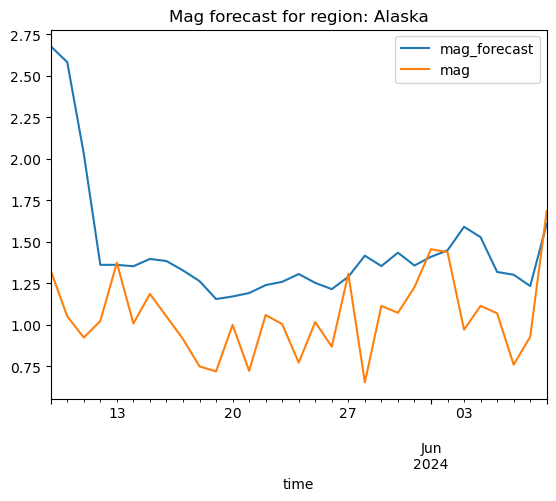

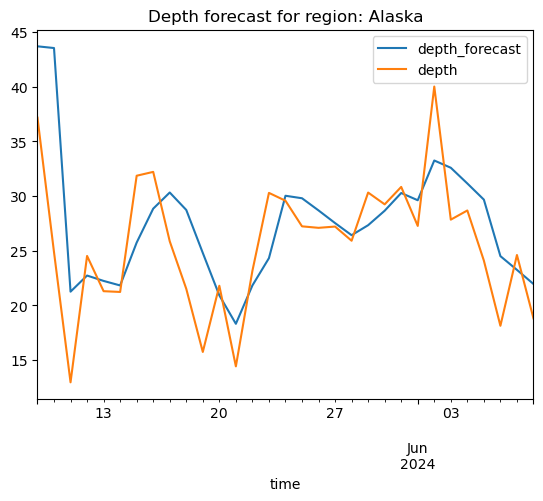

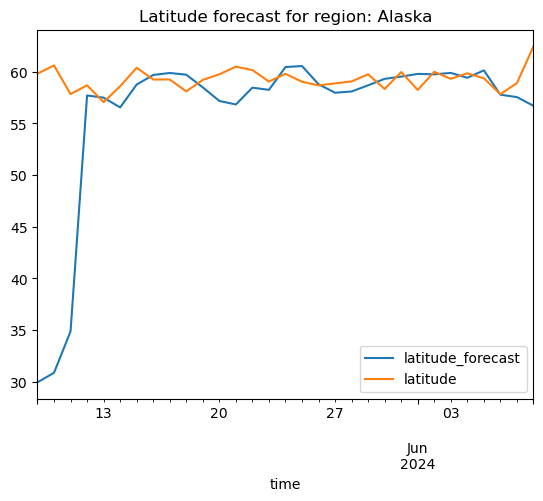

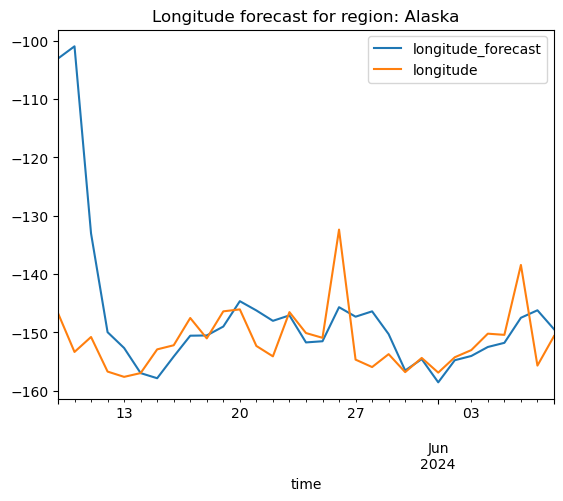

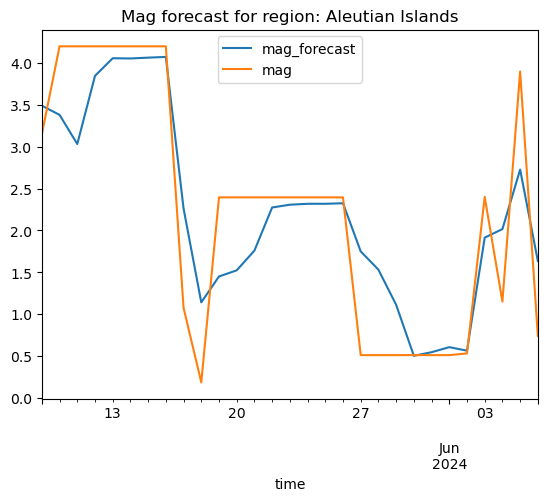

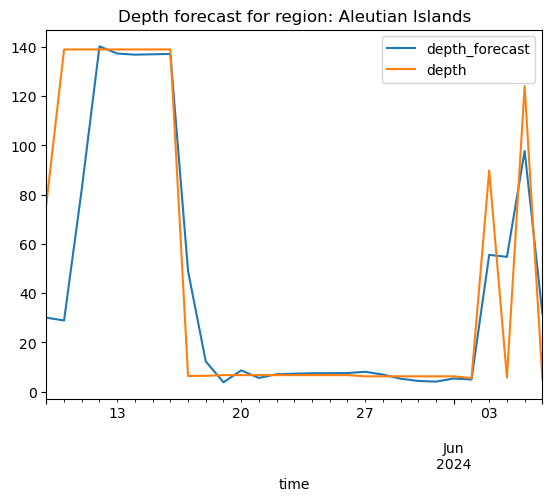

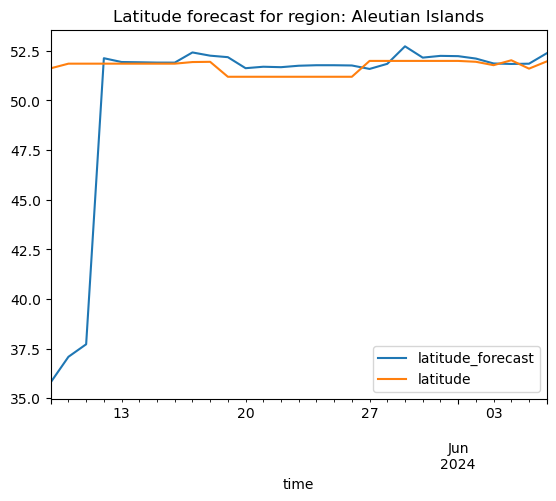

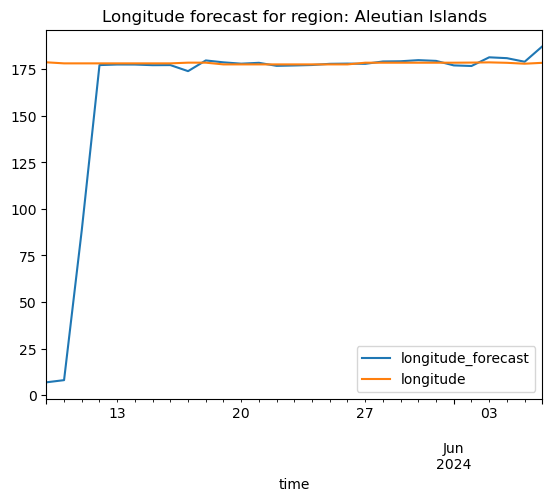

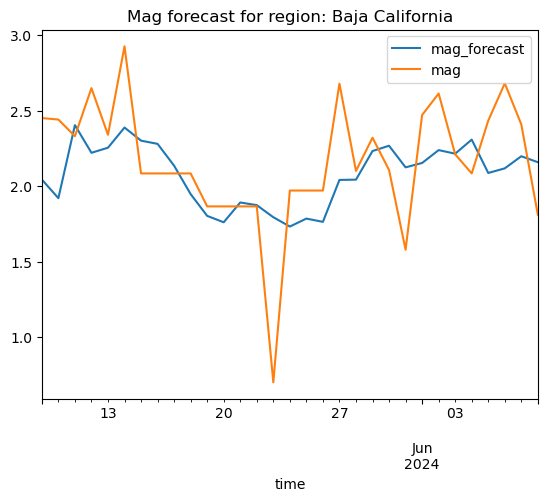

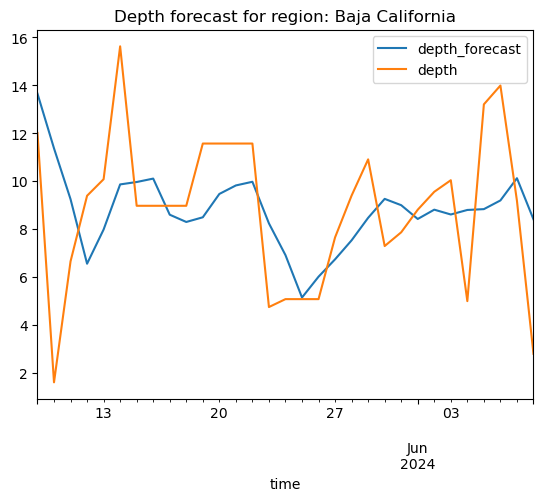

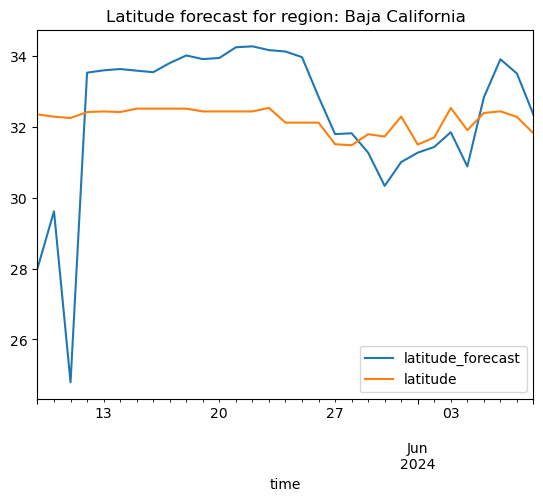

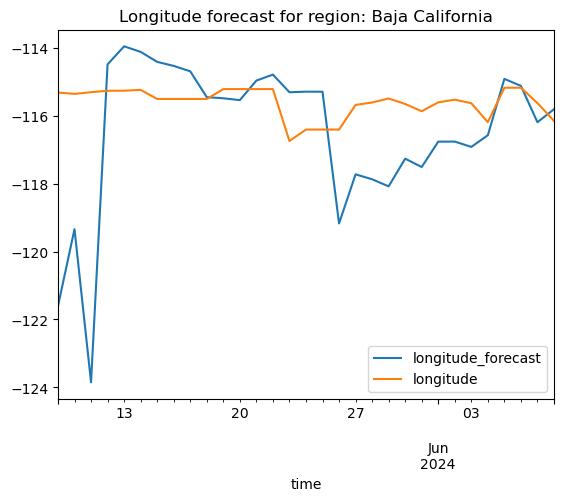

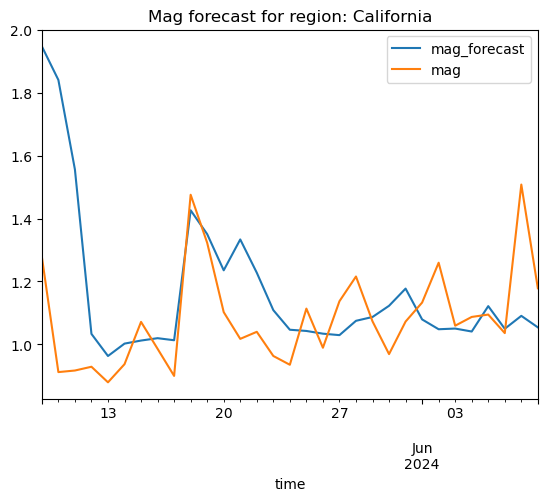

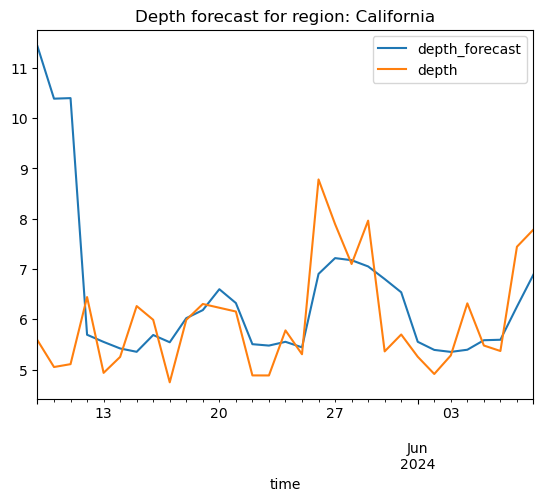

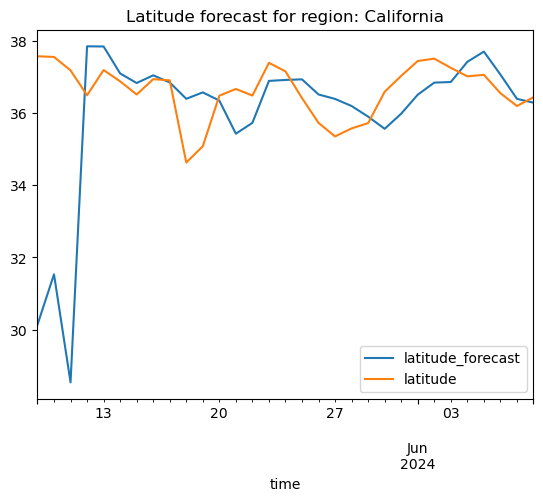

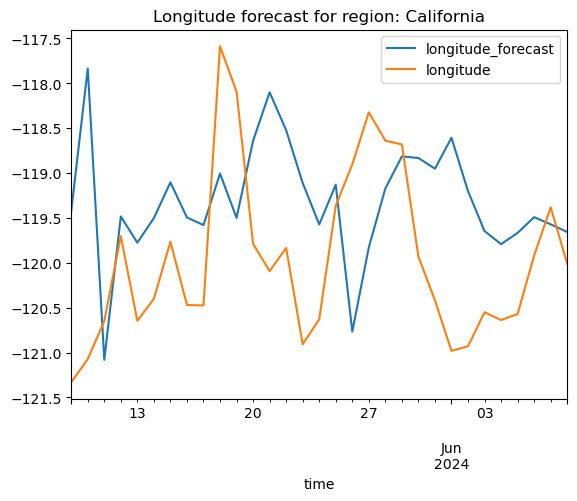

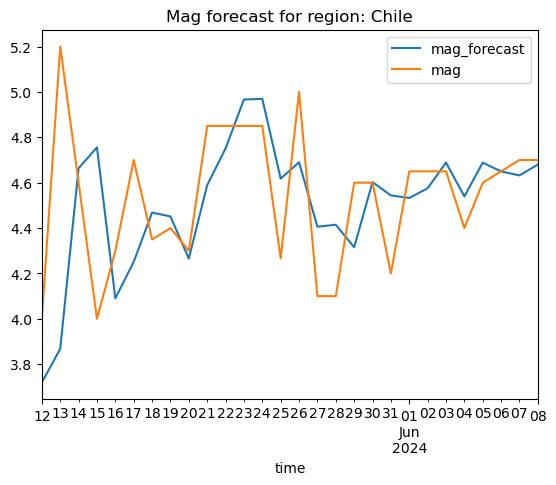

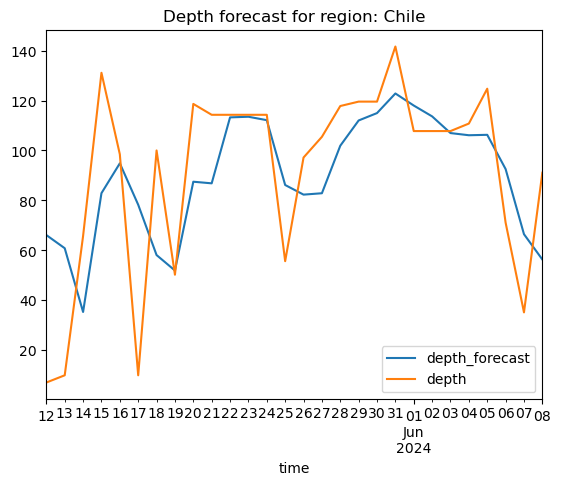

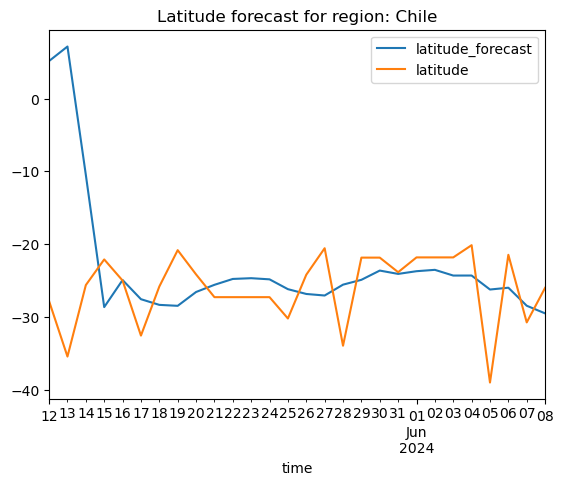

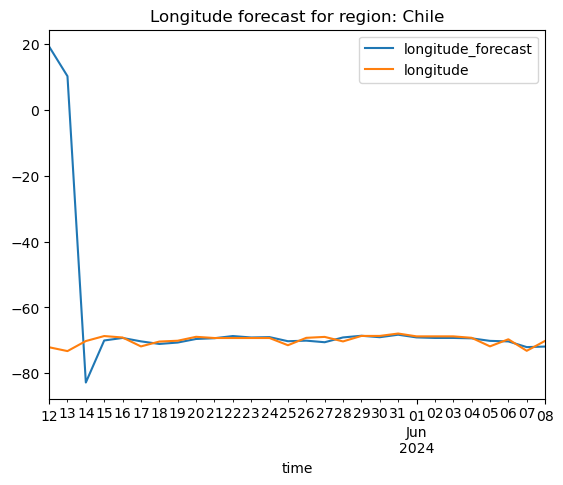

In [11]:
k = 5
for region in df_combined.region.unique():
    df_region = df_combined.loc[df_combined.region == region]
    df_region.plot(title=f"Mag forecast for region: {region}", x='time', y=['mag_forecast', 'mag'])
    df_region.plot(title=f"Depth forecast for region: {region}", x='time', y=['depth_forecast', 'depth'])
    df_region.plot(title=f"Latitude forecast for region: {region}", x='time', y=['latitude_forecast', 'latitude'])
    df_region.plot(title=f"Longitude forecast for region: {region}", x='time', y=['longitude_forecast', 'longitude'])
    k -= 1
    if not k:
        break